In [1]:
"""
The Autonomous Cooperative Consensus Orbit Determination (ACCORD) framework.
Author: Beth Probert
Email: beth.probert@strath.ac.uk

Copyright (C) 2025 Applied Space Technology Laboratory

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

"""

import json
import numpy as np
from datetime import timedelta
from src.consensus_mech import ConsensusMechanism
from src.dag import DAG
from src.satellite_node import SatelliteNode
from src.transaction import Transaction, TransactionMetadata
from src.utils import load_json_data, build_tx_data_str


def run_consensus_demo(n_tx: int = 3) -> DAG:
    """ 
    This function runs a demonstration of the ACCORD Distributed Ledger.
    The following steps are demonstrated:
    - Loading in TLE data from a JSON file
    - Adding transactions to a ledger. The transactions have simulated 
    noise added to their sensor data to reflect real-wold conditions.
    - Once a 4th transaction is added to the ledger, consensus is 
    executed and nodes and transactions are given reputation and consensus
    scores that reflect the trust in the information and the node
    that provided it.

    Arguments:
    - n_tx: An integer representing the number of transactions to be added
    to the ledger, before a test transaction is then added. For consensus 
    to be possible, n_tx must be at least 3, as consensus cannot be reaced 
    with fewer than 4 observations being added to the ledger.

    Returns:
    - The updated Directed Acyclic Graph (DAG) ledger structure, which can 
    then be parsed into other funcions to generate diagrams or analyse data.
    """

    # Load observation data from the orbit determination data JSON file
    satellites = load_json_data("od_data.json")
    if not satellites:
        print("No satellite data found.")
        return

    # Setup the data structures needed for the demo
    test_satellite = SatelliteNode(node_id="SAT-001")
    test_dag = DAG()
    base_sat = satellites[0]

    # Add other transactions into the ledger with some simulated random noise
    # This is bypassing the consensus process to give us foundational data 
    # which can then be built upon, purely for testing purposes. 
    # TODO - test with bigger variants and non-random noise
    # TODO - can this be simplified??
    for i in range(n_tx):
        noise = {
            "mean_motion": np.random.normal(0, 0.01),       # rev/day
            "eccentricity": np.random.normal(0, 0.00002),    # unitless
            "inclination": np.random.normal(0, 0.05),        # degrees
            "epoch_jitter": np.random.normal(0, 2)           # seconds
        }

        # Add noise to the data 
        observed_eccentricity = base_sat.model.ecco + noise["eccentricity"]
        observed_epoch = base_sat.epoch.utc_datetime() + timedelta(seconds=noise["epoch_jitter"])
        observed_inclination = (base_sat.model.inclo * 180 / np.pi) + noise["inclination"]
        observed_mean_motion = ((base_sat.model.no_kozai / (2 * np.pi)) * 1440) + noise["mean_motion"]

        # Add the noisy transaction data to the ledger
        dummy_tx = Transaction(
            sender_address=f"NODE-{i}",
            recipient_address=123,
            sender_private_key="dummy_key",
            metadata=TransactionMetadata(),
            tx_data=json.dumps({
                "OBJECT_NAME": base_sat.name,
                "OBJECT_ID": 25544,
                "EPOCH": observed_epoch.isoformat() + "Z",
                "MEAN_MOTION": observed_mean_motion,
                "ECCENTRICITY": observed_eccentricity,
                "INCLINATION": observed_inclination
            })
        )
        test_dag.add_tx(dummy_tx)

    # Create a new transactional piece of data
    test_transaction = Transaction(sender_address=test_satellite.id,
                                   recipient_address=123,
                                   sender_private_key="dummy_key",
                                   metadata=TransactionMetadata(),
                                   tx_data=build_tx_data_str(base_sat))


    # Initialise PoISE mechanism
    poise = ConsensusMechanism()

    # Run consensus on a single satellite observation - the test transaction
    consensus_result = test_satellite.submit_transaction(dag=test_dag, 
                                                         satellite=base_sat, 
                                                         recipient_address=123, 
                                                         consensus_mech=poise)

    # Output results
    print(f"\nConsensus reached: {consensus_result}")
    print(f"Updated Node Reputation: {test_satellite.reputation:.2f}")
    print(f"Transaction:\n{test_transaction}")
    print(test_dag.ledger)
    return test_dag

# Run demonstration and capture DAG object for use in other functions
test_dag = run_consensus_demo()



Consensus reached: True
Updated Node Reputation: 0.10
Transaction:
Transaction(
  sender_address=SAT-001,
  recipient_address=123,
  timestamp=2025-08-11 14:13:14.509888,
  tx_data='{"OBJECT_NAME": "ISS (ZARYA)", "OBJECT_ID": "1998-067A", "EPOCH": "2024-05-06T19:53:04.999776", "MEAN_MOTION": 15.50957674, "ECCENTRICITY": 0.000358, "INCLINATION": 51.6393, "RA_OF_ASC_NODE": 160.4574, "ARG_OF_PERICENTER": 140.6673, "MEAN_ANOMALY": 205.725, "EPHEMERIS_TYPE": 0, "CLASSIFICATION_TYPE": "U", "NORAD_CAT_ID": 25544, "ELEMENT_SET_NO": 999, "REV_AT_EPOCH": 45212, "BSTAR": 0.0002731, "MEAN_MOTION_DOT": 0.00015698, "MEAN_MOTION_DDOT": 0}',
  consensus_reached=False,
  is_confirmed=False,
  is_rejected=False,
  confirmation_score=0.0,
  parent_hashes=[],
  hash=7fa06ec86f...)

OrderedDict({'Genesis Transaction 1': [Transaction(
  sender_address=0,
  recipient_address=0,
  timestamp=2025-08-11 14:13:14.302326,
  tx_data='Genesis Transaction 1',
  consensus_reached=True,
  is_confirmed=True,
  is_reje

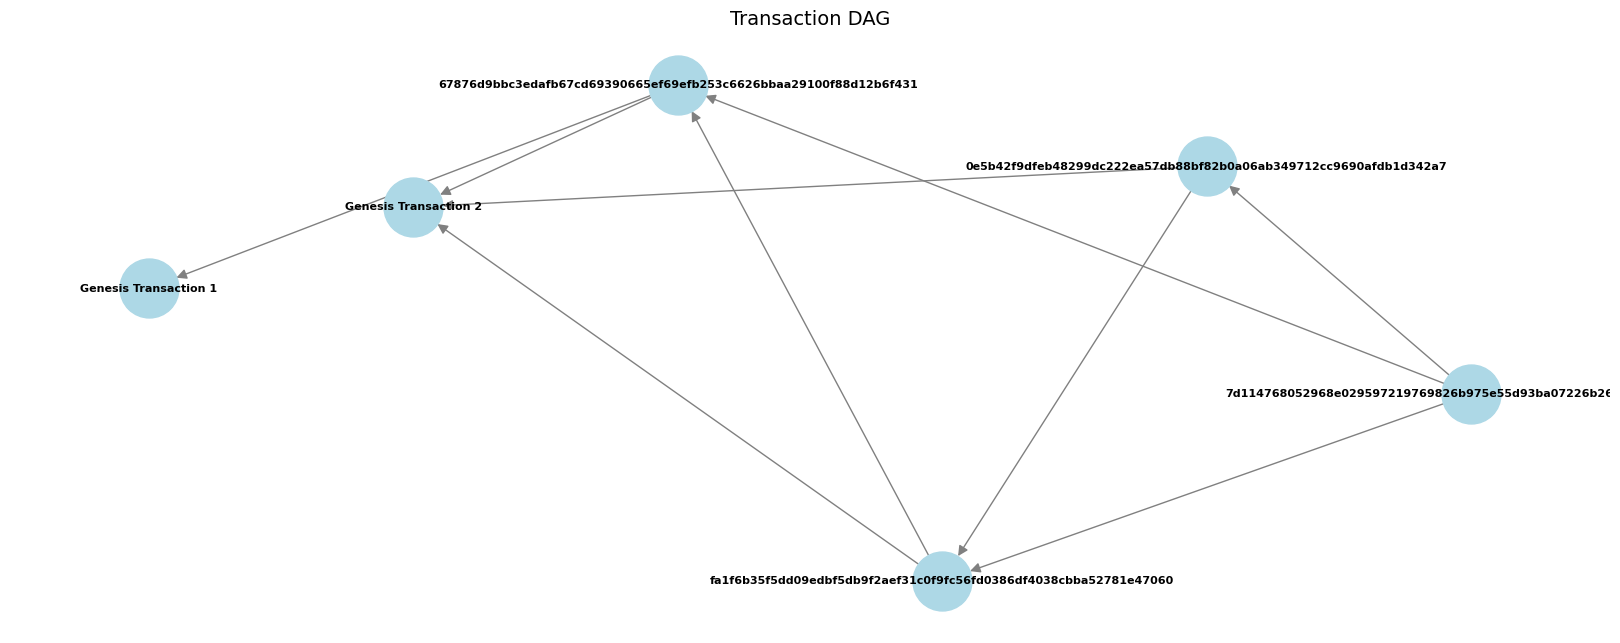

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_transaction_dag(dag: DAG) -> None:
    """
    Plot a network diagram representing the data stored in the DAG ledger.

    Arguments:
    - dag: The Directed Acyclic Graph distributed ledger data structure.

    Returns:
    None. Renders a diagram using MatPlotLib.
    """

    # Initialise striuctures for the diagram
    # DiGraph is a directed graph
    G = nx.DiGraph()
    # Timestamps are used to order the graph
    tx_timestamps = {}

    # Add nodes and edges to the graph
    # Edges are added between transactions and their parents
    for key, tx_list in dag.ledger.items():
        for tx in tx_list:
            G.add_node(key)
            tx_timestamps[key] = tx.metadata.timestamp
            for parent_hash in tx.metadata.parent_hashes:
                G.add_edge(key, parent_hash)

    # Sort by timestamp for left-to-right X-axis
    sorted_keys = sorted(tx_timestamps, key=lambda k: tx_timestamps[k])

    # Add coordinates for each node (transaction) in the graph
    # In X, they are sorted chronologically
    # In Y, they are spaced out for visibility
    pos = {}
    
    for i, key in enumerate(sorted_keys):
        x = i
        # Deterministic Y based on hash
        y = (hash(key) % 100) / 100.0 - 0.5  # in range [-0.5, 0.5]
        pos[key] = (x, y)

    # Plot the figure
    plt.figure(figsize=(16, 6))
    nx.draw(G, pos, with_labels=True,
            node_color='lightblue', node_size=1800,
            font_size=8, font_weight='bold',
            edge_color='gray', arrowsize=15)

    plt.title("Transaction DAG", fontsize=14)
    plt.axis("off")
    plt.show()



plot_transaction_dag(test_dag)
